In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils.load_data_for_eda import load_data
from utils.effect_sizes import compute_effect_sizes_by_group, compute_effect_sizes_by_commodity, compare_eta_omega
df = load_data('data/commodity_prices.csv')
df = compute_effect_sizes_by_group(df)
df = compute_effect_sizes_by_commodity(df)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option("display.max_colwidth", None)

In [ ]:
suspicious_df = compare_eta_omega(df)
drop_cols = ['Arrival_Date', 'Min_Price', 'Max_Price', 'Modal_Price']
suspicious_df.drop(columns=drop_cols, inplace=True)
suspicious_df = suspicious_df.drop_duplicates()
suspicious_df.head(20)

,Product_Type,Commodity,Variety_Type,Market,Is_VFPCK,Season,Year,eta2_Season,omega2_Season,eta2_Market,omega2_Market,eta2_Year,omega2_Year,eta2_Commodity,omega2_Commodity,eta2_Variety_Type,omega2_Variety_Type,eta2-omega2_diff_Commodity,eta2/omega2_ratio_Commodity,feature_flagged,eta2-omega2_diff_Variety_Type,eta2/omega2_ratio_Variety_Type,eta2-omega2_diff_Season,eta2/omega2_ratio_Season,eta2-omega2_diff_Market,eta2/omega2_ratio_Market,eta2-omega2_diff_Year,eta2/omega2_ratio_Year


Eta² vs. Omega² Consistency Check

To evaluate the influence of features on commodity price variation, we compared η² (eta squared) and ω² (omega squared) effect sizes.
	•	In some cases (e.g., Season in Banana|Poovan|Small), η² was high while ω² was much lower, suggesting η² was inflating the effect.
	•	Similarly, features like Market in Banana|Robusta|Small showed discrepancies between η² and ω².
	•	These mismatches indicate unstable variance estimates, where η² may overstate the true explanatory power of a feature.

To guard against this, we adopted a dual-threshold approach to define “important features”:
	•	η² ≥ 0.05 → captures observed influence.
	•	ω² ≥ 0.02 → filters out likely noise.
This ensures that only robust and truly influential features are carried forward, avoiding noise-driven false positives.

Notably, before filtering, several rows were flagged where η² and ω² diverged significantly. However, after applying the ≥50 record cutoff, these suspicious cases disappeared, confirming that the threshold stabilized the effect size calculations and reduced the risk of inflated estimates.

In [4]:
def important_features(row, threshold_eta=0.05, threshold_omega=0.02):
    features = []
    for col in ['Commodity','Variety_Type','Season','Market','Year']:
        if (row[f'eta2_{col}'] >= threshold_eta) & (row[f'omega2_{col}'] >= threshold_omega):
            features.append(col)
    if not features:
        return 'None'
    else:
        return '|'.join(features) 

df['important_features'] = df.apply(important_features, axis=1)

In [5]:
df_none = df[df['important_features'] == 'None']
df_none[['Product_Type', 'Market', 'Year', 'eta2_Commodity', 'eta2_Variety_Type', 'eta2_Season', 'eta2_Market', 'eta2_Year', 'omega2_Commodity', 'omega2_Variety_Type', 'omega2_Season', 'omega2_Market', 'omega2_Year', 'important_features']].drop_duplicates()

,Product_Type,Market,Year,eta2_Commodity,eta2_Variety_Type,eta2_Season,eta2_Market,eta2_Year,omega2_Commodity,omega2_Variety_Type,omega2_Season,omega2_Market,omega2_Year,important_features
129938,Papaya (Raw)|Other|FAQ,Piravam,2025,0.0,0.0,0.030107,0.0,0.0,0.0,0.0,0.011871,0.0,0.0,None


In [11]:
df = df[df['important_features'] != 'None']

In [18]:
df_grouped = df.groupby(['important_features', 'Product_Type', 'Market']).agg(
    Mean_Commodity_Effect_Size=('eta2_Commodity', 'mean'),
    Mean_Variety_Type_Effect_Size=('eta2_Variety_Type', 'mean'),
    Mean_Season_Effect_Size=('eta2_Season', 'mean'),
    Mean_Market_Effect_Size=('eta2_Market', 'mean'),
    Mean_Year_Effect_Size=('eta2_Year', 'mean'),
    Total_Records=('Product_Type', 'count')
).reset_index()
df_grouped.to_csv('data/important_feature_groups.csv', index=False)
df_grouped.head(20)


,important_features,Product_Type,Market,Mean_Commodity_Effect_Size,Mean_Variety_Type_Effect_Size,Mean_Season_Effect_Size,Mean_Market_Effect_Size,Mean_Year_Effect_Size,Total_Records
0,Commodity,Banana|Nendra Bale|Medium,THURAVOOR VFPCK,0.650715,0.00014,0.000149,0.000000,0.000000,65
1,Commodity,Capsicum|Other|FAQ,Piravam,0.057064,0.00000,0.031460,0.000000,0.008407,502
2,Commodity|Market,Amaranthus|Amaranthus|FAQ,Aluva,0.152055,0.00000,0.012549,0.745668,0.014132,587
3,Commodity|Market,Amaranthus|Amaranthus|FAQ,Angamaly,0.152055,0.00000,0.012549,0.745668,0.014132,570
4,Commodity|Market,Amaranthus|Amaranthus|FAQ,Broadway market,0.152055,0.00000,0.012549,0.745668,0.014132,394
5,Commodity|Market,Amaranthus|Amaranthus|FAQ,Ernakulam,0.152055,0.00000,0.012549,0.745668,0.014132,518
6,Commodity|Market,Amaranthus|Amaranthus|FAQ,North Paravur,0.152055,0.00000,0.012549,0.745668,0.014132,452
7,Commodity|Market,Amaranthus|Amaranthus|FAQ,Perumbavoor,0.152055,0.00000,0.012549,0.745668,0.014132,647
8,Commodity|Market,Cucumbar(Kheera)|Cucumbar|FAQ,Aluva,0.084161,0.00000,0.047627,0.443961,0.037630,606
9,Commodity|Market,Cucumbar(Kheera)|Cucumbar|FAQ,Broadway market,0.084161,0.00000,0.047627,0.443961,0.037630,415


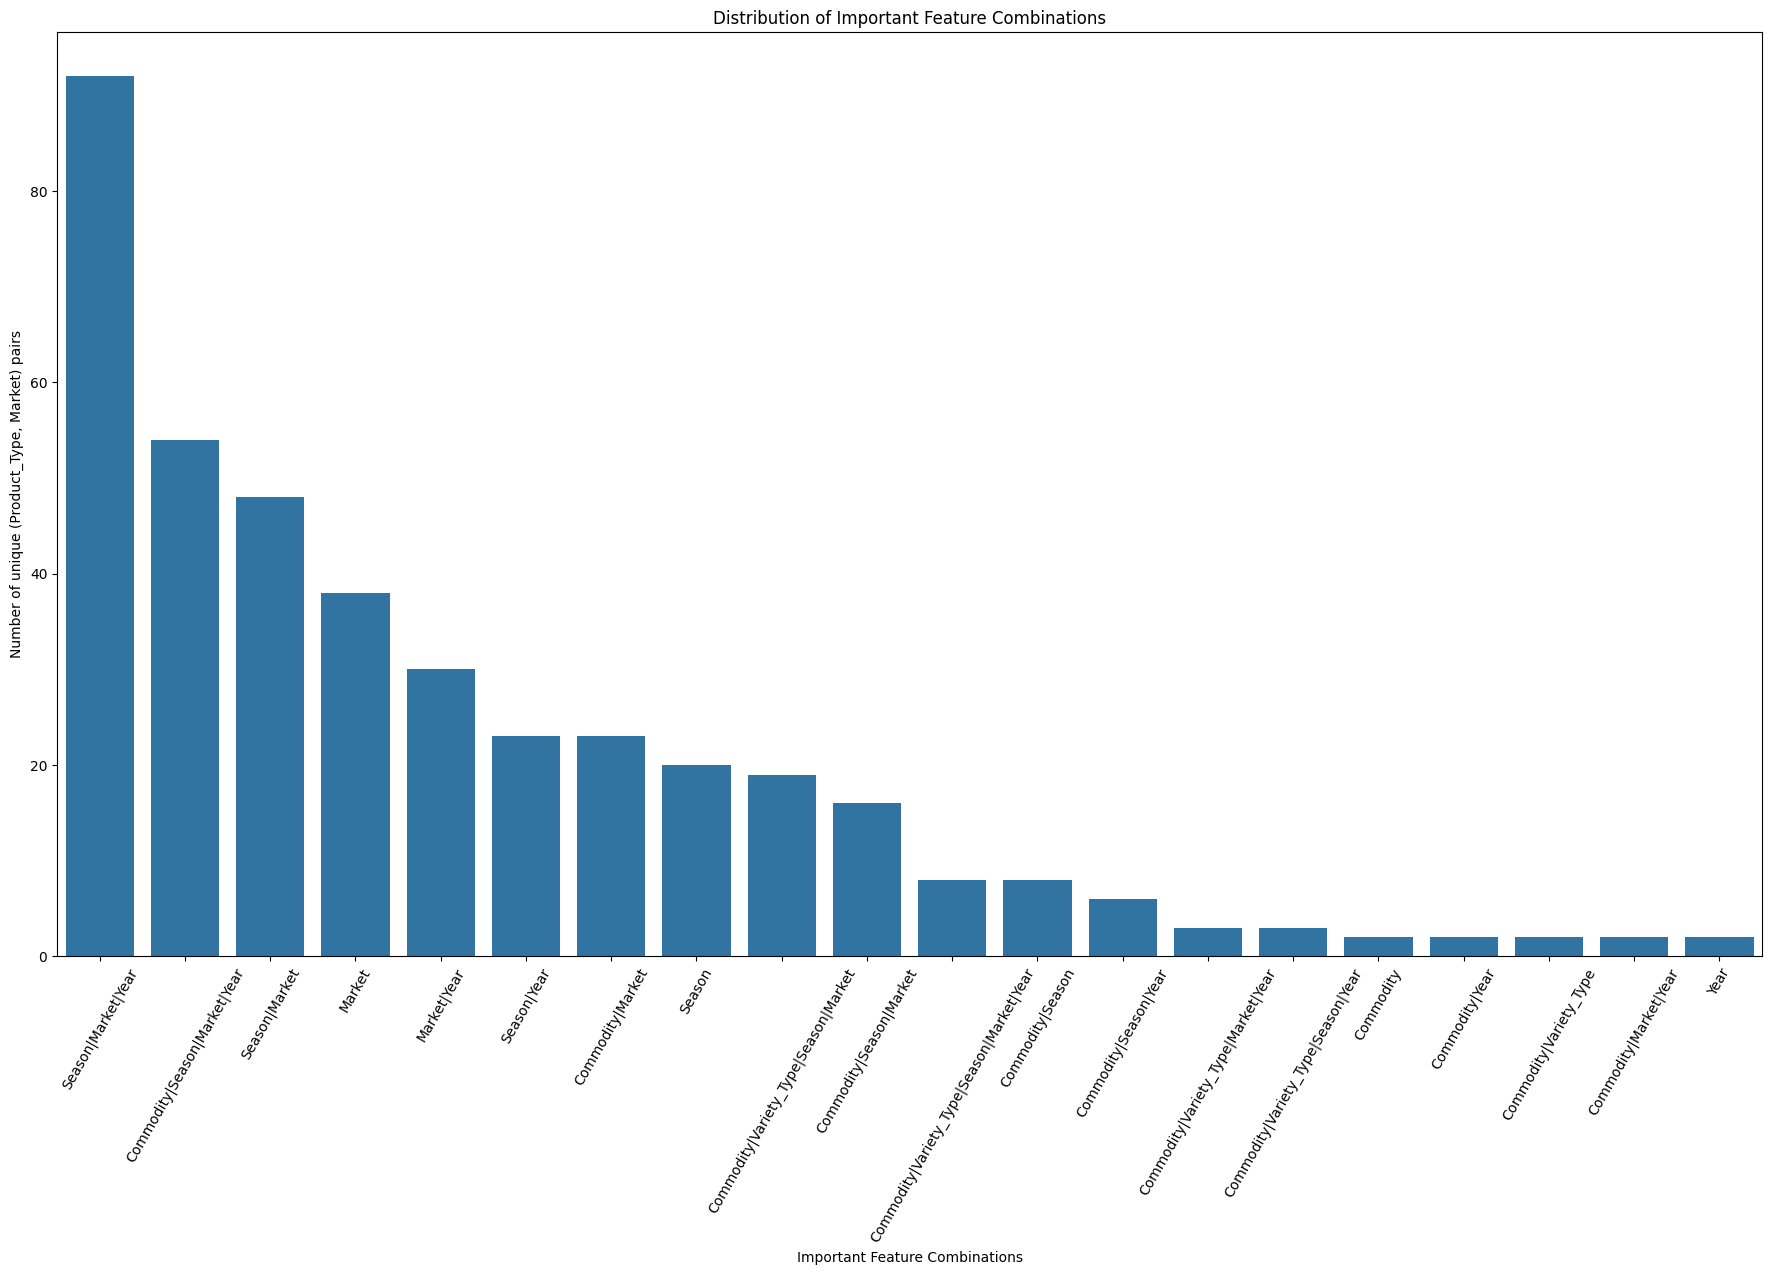

In [13]:
group_counts = df_grouped['important_features'].value_counts().reset_index()
fig, ax = plt.subplots(figsize=(22, 12))
sns.barplot(data=group_counts, x='important_features', y='count', ax=ax)
ax.set_title('Distribution of Important Feature Combinations')
ax.set_xlabel('Important Feature Combinations')
ax.set_ylabel('Number of unique (Product_Type, Market) pairs')
plt.xticks(rotation=60)
plt.show()  

Distribution of Total Records per (Product_Type, Market) pair

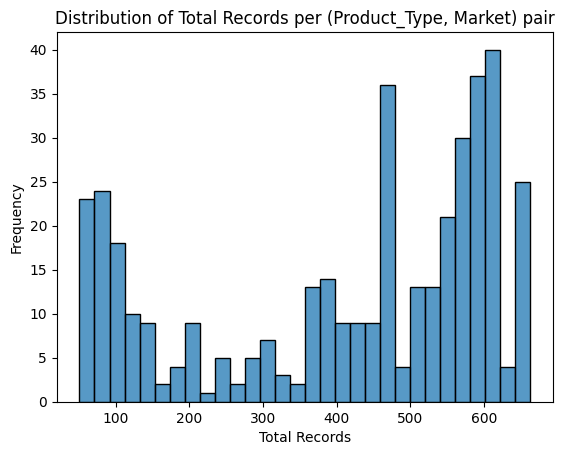

In [14]:
sns.histplot(df_grouped['Total_Records'], bins=30)
plt.title('Distribution of Total Records per (Product_Type, Market) pair')
plt.xlabel('Total Records')
plt.ylabel('Frequency')
plt.show()  

In [17]:
group_counts

,important_features,count
0,Season|Market|Year,92
1,Commodity|Season|Market|Year,54
2,Season|Market,48
3,Market,38
4,Market|Year,30
5,Season|Year,23
6,Commodity|Market,23
7,Season,20
8,Commodity|Variety_Type|Season|Market,19
9,Commodity|Season|Market,16


Mean Effect Sizes by Important Feature Combinations

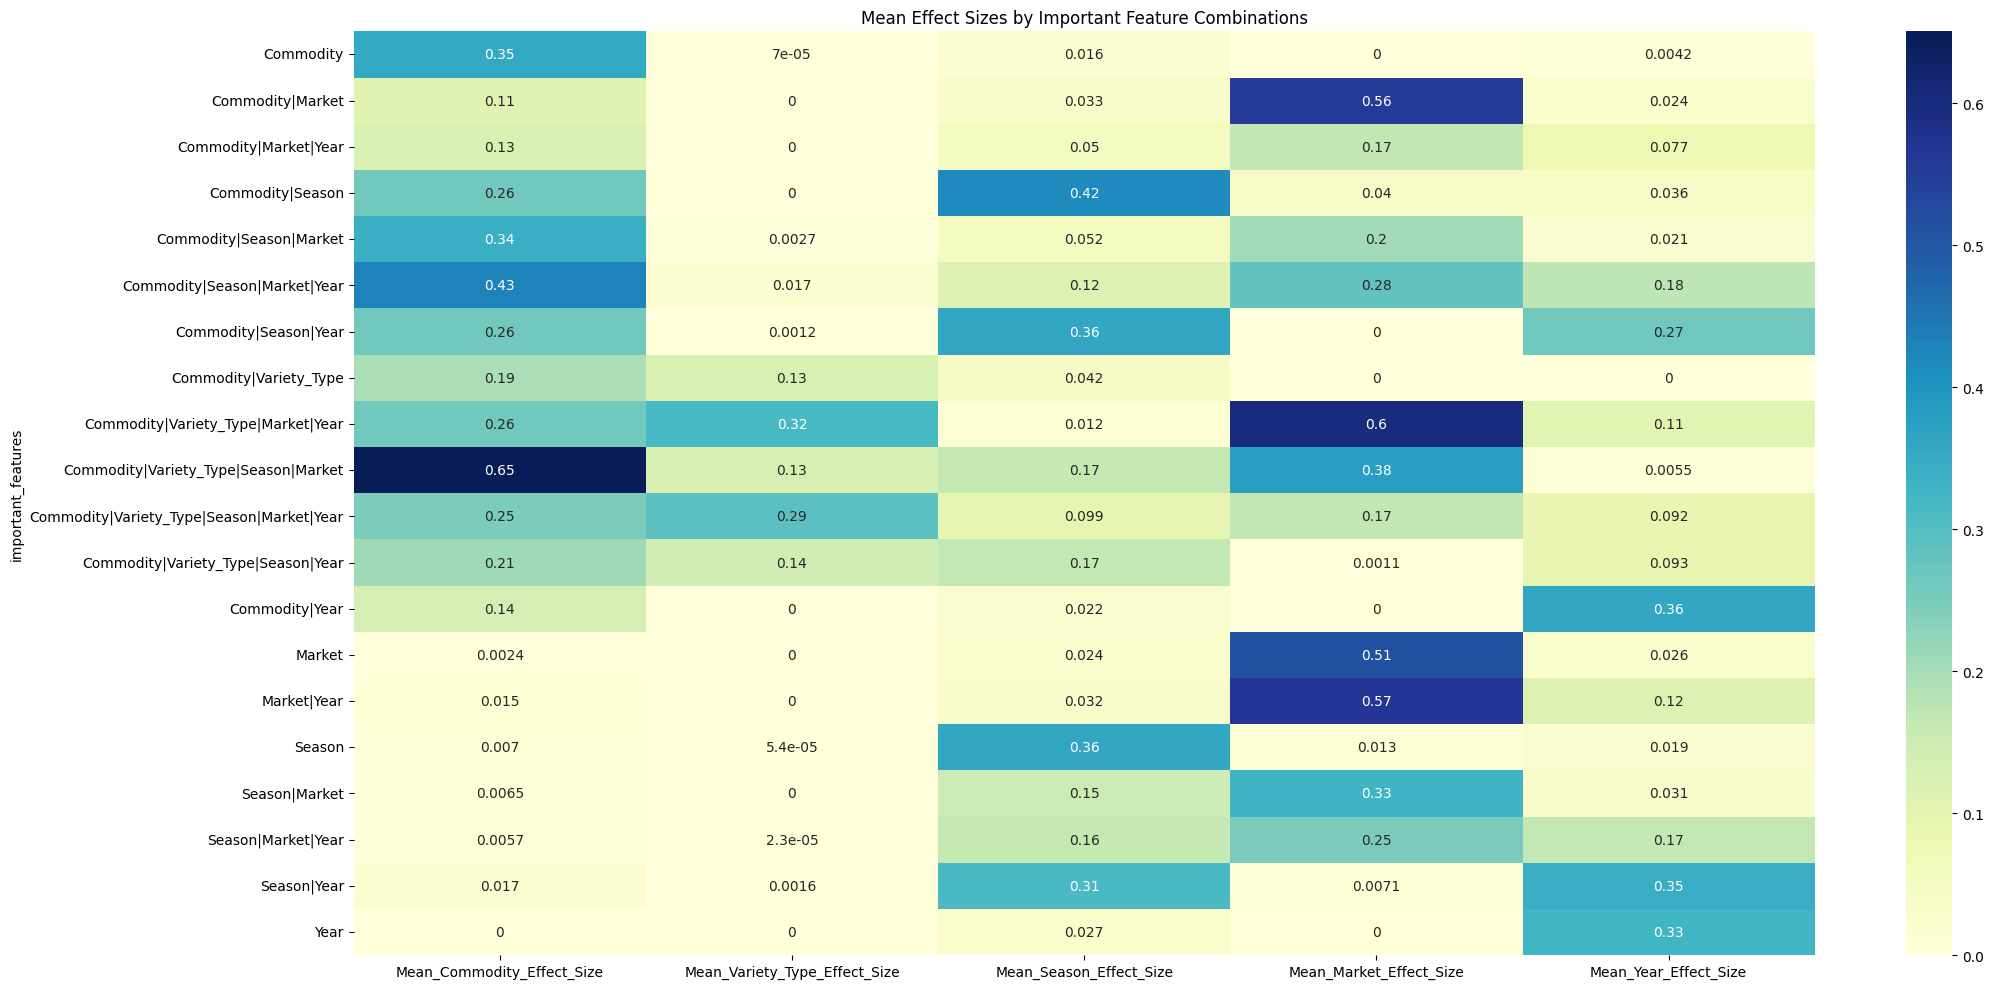

In [16]:
# Aggregate mean by important_features
heatmap_data = df_grouped.groupby('important_features')[
    ['Mean_Commodity_Effect_Size', 'Mean_Variety_Type_Effect_Size', 
     'Mean_Season_Effect_Size', 'Mean_Market_Effect_Size', 'Mean_Year_Effect_Size']
].mean()

# Plot heatmap
fig, ax = plt.subplots(figsize=(22, 10))
sns.heatmap(data=heatmap_data, annot=True, cmap='YlGnBu', ax=ax)
ax.set_title('Mean Effect Sizes by Important Feature Combinations')
plt.tight_layout()
plt.show()

In [62]:
data = df_grouped[
    ['Mean_Commodity_Effect_Size', 'Mean_Variety_Type_Effect_Size', 
     'Mean_Season_Effect_Size', 'Mean_Market_Effect_Size', 'Mean_Year_Effect_Size']
].set_index(df_grouped['important_features']).drop_duplicates()

data.head(20)

,Mean_Commodity_Effect_Size,Mean_Variety_Type_Effect_Size,Mean_Season_Effect_Size,Mean_Market_Effect_Size,Mean_Year_Effect_Size
important_features,,,,,
Commodity,0.057064,0.000000,0.031460,0.000000,0.008407
Commodity|Market,0.149755,0.000000,0.012293,0.746367,0.013385
Commodity|Market,0.149755,0.000000,0.012293,0.746367,0.013385
Commodity|Market,0.083959,0.000000,0.049458,0.440824,0.037294
Commodity|Market,0.083959,0.000000,0.049458,0.440824,0.037294
Commodity|Market,0.083959,0.000000,0.049458,0.440824,0.037294
Commodity|Market,0.083959,0.000000,0.049458,0.440824,0.037294
Commodity|Market,0.083959,0.000000,0.049458,0.440824,0.037294
Commodity|Market,0.083959,0.000000,0.031242,0.721173,0.006402


In [ ]:
df_grouped[['important_features', 'Product_Types']]

In [3]:
df[df['eta2_Commodity'] >= 0.1][['Product_Type', 'eta2_Commodity', 'omega2_Commodity']].drop_duplicates()

,Product_Type,eta2_Commodity,omega2_Commodity
471,Amaranthus|Amaranthus|FAQ,0.149755,0.149530
3648,Amaranthus|Other|FAQ,0.149755,0.149530
20696,Banana|Nendra Bale|Large,0.645850,0.645579
25696,Banana|Nendra Bale|Medium,0.645850,0.645579
25837,Banana|Nendra Bale|Small,0.645850,0.645579
25870,Banana|Other|Large,0.645850,0.645579
25945,Banana|Other|Medium,0.645850,0.645579
26028,Banana|Palayamthodan|Large,0.645850,0.645579
29555,Banana|Palayamthodan|Medium,0.645850,0.645579
32172,Banana|Palayamthodan|Small,0.645850,0.645579


In [4]:
df[df['eta2_Variety_Type'] >= 0.1][['Product_Type', 'eta2_Variety_Type', 'omega2_Variety_Type']].drop_duplicates()

,Product_Type,eta2_Variety_Type,omega2_Variety_Type
26028,Banana|Palayamthodan|Large,0.123560,0.123260
29555,Banana|Palayamthodan|Medium,0.123560,0.123260
32172,Banana|Palayamthodan|Small,0.123560,0.123260
126416,Onion|1st Sort|FAQ,0.199267,0.198114
127142,Onion|1st Sort|Non-FAQ,0.199267,0.198114
132863,Pineapple|Other|Large,0.284891,0.284471
134808,Pineapple|Other|Medium,0.284891,0.284471
136209,Pineapple|Other|Small,0.284891,0.284471


“While market, season, and year effects dominate overall, certain commodities (notably Banana, Pineapple, Onion) show strong within-commodity variety-level effects. This justifies treating Commodity and Variety as important features in price modeling.”

In [6]:
threshold = 0.05  # meaning feature explains <5% of variance, consider it negligible
df_basic = df[(df['eta2_Commodity'] < threshold) & 
              (df['eta2_Variety_Type'] < threshold) &
              (df['eta2_Season'] < threshold) &
              (df['eta2_Market'] < threshold) &
              (df['eta2_Year'] < threshold)]
df_basic

,Product_Type,Commodity,Variety_Type,Arrival_Date,Market,Is_VFPCK,Season,Year,Modal_Price,Max_Price,...,eta2_Season,omega2_Season,eta2_Market,omega2_Market,eta2_Year,omega2_Year,eta2_Commodity,omega2_Commodity,eta2_Variety_Type,omega2_Variety_Type


In [7]:
df_simple = df[(df['eta2_Market'] == 0.0) & (df['eta2_Year'] == 0.0) & (df['eta2_Season'] == 0.0) & (df['eta2_Variety_Type'] == 0.0) & (df['eta2_Commodity'] == 0.0)]
df_simple

,Product_Type,Commodity,Variety_Type,Arrival_Date,Market,Is_VFPCK,Season,Year,Modal_Price,Max_Price,Min_Price,eta2_Season,omega2_Season,eta2_Market,omega2_Market,eta2_Year,omega2_Year,eta2_Commodity,omega2_Commodity,eta2_Variety_Type,omega2_Variety_Type,eta2-omega2_diff_Commodity,eta2/omega2_ratio_Commodity,eta2-omega2_diff_Variety_Type,eta2/omega2_ratio_Variety_Type,eta2-omega2_diff_Season,eta2/omega2_ratio_Season,eta2-omega2_diff_Market,eta2/omega2_ratio_Market,eta2-omega2_diff_Year,eta2/omega2_ratio_Year,important_features


In [30]:
df[df['Product_Type'].str.contains('Coriander')]['Product_Type'].value_counts()

Product_Type
Coriander(Leaves)|Coriander|FAQ    449
Coriander(Leaves)|Other|FAQ        151
Name: count, dtype: int64

In [33]:
df[df['Product_Type'] == 'Coriander(Leaves)|Coriander|FAQ']['Season'].value_counts()

Season
Summer               142
Southwest Monsoon    129
Winter               108
Post Monsoon          70
Name: count, dtype: int64

In [32]:
df[df['Product_Type'] == 'Coriander(Leaves)|Other|FAQ']['Market'].value_counts()

Market
Piravam    151
Name: count, dtype: int64

In [16]:
df_simple['Product_Type'].value_counts()

Product_Type
Coriander(Leaves)|Other|FAQ      151
Orange|Other|Large               149
Sweet Potato|Other|FAQ           140
Tomato|Deshi|Non-FAQ             122
Water Melon|Water Melon|Large    119
Onion|1st Sort|Non-FAQ           108
Potato|(Red Nanital)|Non-FAQ     108
Long Melon(Kakri)|Other|FAQ       98
Egg|Egg|FAQ                       26
Name: count, dtype: int64

In [26]:
df_simple[['Product_Type', 'eta2_Season', 'omega2_Season']].drop_duplicates()

,Product_Type,eta2_Season,omega2_Season
83938,Coriander(Leaves)|Other|FAQ,0.175735,0.163685
97951,Egg|Egg|FAQ,0.500000,0.446809
122165,Long Melon(Kakri)|Other|FAQ,0.234177,0.216311
127142,Onion|1st Sort|Non-FAQ,0.035741,0.017216
131281,Orange|Other|Large,0.534722,0.526670
141142,Potato|(Red Nanital)|Non-FAQ,0.047642,0.029236
156151,Sweet Potato|Other|FAQ,0.359891,0.348916
163816,Tomato|Deshi|Non-FAQ,0.604214,0.595581
167831,Water Melon|Water Melon|Large,0.100681,0.084521


In [4]:
df['eta2_Market'].nunique(), df['omega2_Market'].nunique(), df['eta2_Season'].nunique(), df['omega2_Season'].nunique(), df['eta2_Year'].nunique(), df['omega2_Year'].nunique(), df['eta2_Commodity'].nunique(), df['omega2_Commodity'].nunique()

(98, 98, 124, 124, 112, 112, 1, 1)